# Test 2: Compare with Greedy

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import sys
import seaborn as sns
import numpy as np

# Try to get the script directory; if in a notebook, use the current working directory
try:
    SCRIPT_DIR = Path(__file__).resolve().parent
except NameError:
    # We are in a notebook/interactive session
    SCRIPT_DIR = Path(os.getcwd()).resolve()

# Adjust this based on where your 'logs' folder is relative to the notebook
# If 'logs' is in the same folder as your notebook, use SCRIPT_DIR
# If 'logs' is one level up, use SCRIPT_DIR.parent
PROJECT_ROOT = SCRIPT_DIR.parent

# LOG_FILE = PROJECT_ROOT / "logs" / "compare_k_log.csv"
LOG_FILE = PROJECT_ROOT / "logs" 
PLOT_DIR = PROJECT_ROOT / "logs" / "plots"

print(f"Looking for log file at: {LOG_FILE}")

def load_data(LOG_FILE):
    if not os.path.exists(LOG_FILE):
        print(f"Error: Log file not found at {LOG_FILE}")
        sys.exit(1)

    try:
        df = pd.read_csv(LOG_FILE)
        # Clean column names (remove spaces)
        df.columns = df.columns.str.strip()
        df.columns = df.columns.str.lower()
        
        # Rename
        if "dataset_name" in df.columns:
            df.rename(columns={"dataset_name": "dataset"})
        if "g_obj" in df.columns:
            df.rename(columns={"g_obj": "greedy_obj"})
        if "speedupx" in df.columns:
            df.rename(columns={"speedupx": "speedup_x"})
        df = df[df['steps'] >= 1000]
        df['rel_err'] = (1 - df['ratio']) * 100 
        df['k_ratio'] = df['k'] / df['p'] 
        return df
    except Exception as e:
        print(f"Error reading CSV: {e}")
        sys.exit(1)
    
    


Looking for log file at: /Users/nautilus/gridfw/logs


In [25]:
SPARSE_LOG = LOG_FILE / "compare_small_k.csv"
ENTIRE_LOG = LOG_FILE / "compare_k_log.csv"
sparse_df = load_data(SPARSE_LOG)
df = load_data(ENTIRE_LOG)

# Cleaning make sure step size

In [36]:
df[df['steps'] >= 1000]

,timestamp,dataset,p,experiment,k,steps,samples,alpha,greedy_obj,fw_obj,ratio,greedy_time_s,fw_time_s,speedup_x,status,rel_err,k_ratio
0,2026-01-28 17:30:59,Secom,478,compare_k239_a0.2_m200_block_1,239,4780,200,0.2,473.2312,472.4897,0.9984,32.0804,25.6579,1.2503,DONE,0.16,0.500000
3,2026-01-28 17:31:25,Secom,478,compare_k143_a0.2_m500_block_1,143,2860,500,0.2,429.4074,425.6511,0.9913,10.1344,31.4337,0.3224,DONE,0.87,0.299163
4,2026-01-28 17:31:39,Secom,478,compare_k95_a0.2_m500_block_1,95,1900,500,0.2,375.7530,369.6303,0.9837,3.6402,22.2053,0.1639,DONE,1.63,0.198745
5,2026-01-28 17:31:45,Synthetic_high_corr,500,compare_k5_a0.1_m20_block_1,5,1000,20,0.1,123.6937,122.9661,0.9941,0.0579,2.9501,0.0196,DONE,0.59,0.010000
6,2026-01-28 17:31:46,Secom,478,compare_k239_a0.2_m200_block_1,239,4780,200,0.2,473.2312,472.6419,0.9988,32.7733,28.0381,1.1689,DONE,0.12,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,2026-01-28 18:45:21,Myocardial,111,compare_k1_a0.2_m500_block_1,1,1000,500,0.2,2.8590,2.8590,1.0000,0.0013,2.4121,0.0005,DONE,0.00,0.009009
432,2026-01-28 18:45:23,Myocardial,111,compare_k11_a0.2_m500_block_1,11,1000,500,0.2,21.5093,21.1036,0.9811,0.0133,2.4171,0.0055,DONE,1.89,0.099099
433,2026-01-28 18:45:26,Myocardial,111,compare_k22_a0.2_m500_block_1,22,1000,500,0.2,35.2432,34.6643,0.9836,0.0327,2.3891,0.0137,DONE,1.64,0.198198
434,2026-01-28 18:45:28,Myocardial,111,compare_k33_a0.2_m500_block_1,33,1000,500,0.2,46.9708,46.4971,0.9899,0.0614,2.3978,0.0256,DONE,1.01,0.297297


# Table and important values

In [28]:
def extract_table(df, dataset_names=None, tolerance=-3.0 ):
    df = df.copy()
    results = []
    
    # Iterate through each unique Dataset and Sample Size (m)
    for (ds, m), group in df.groupby(['dataset', 'samples']):
        
        # A. Max Speedup
        max_speedup = group['speedup_x'].max()
        
        # B. Critical k/p (First ratio where error stays above tolerance)
        # Sort by k_ratio to check the path
        sorted_group = group.sort_values('k_ratio')
        critical_kp = np.nan
        for i in range(len(sorted_group)):
            # Check if current and all subsequent errors are above threshold
            if (sorted_group.iloc[i:]['rel_err'] >= tolerance).all():
                critical_kp = sorted_group.iloc[i]['k_ratio']
                break
        
        # C. Max Error (Worst case) and its location
        max_err_idx = group['rel_err'].idxmax() # Most negative
        max_err_val = group.loc[max_err_idx, 'rel_err']
        max_err_loc = group.loc[max_err_idx, 'k_ratio']
        
        # D. Min Error (Best case) and its location
        min_err_idx = group['rel_err'].idxmin() # Most positive/closest to zero
        min_err_val = group.loc[min_err_idx, 'rel_err']
        min_err_loc = group.loc[min_err_idx, 'k_ratio']
        
        results.append({
            "Dataset": ds,
            "m": m,
            "Max Speedup": f"{max_speedup:.2f}x",
            "Critical k/p": f"{critical_kp:.3f}" if not np.isnan(critical_kp) else "> 0.5",
            "Max Error %": f"{max_err_val:.2f}% (at {max_err_loc:.2f})",
            "Min Error %": f"{min_err_val:.2f}% (at {min_err_loc:.2f})"
        })

    return pd.DataFrame(results).sort_values(['Dataset', 'm'])

In [38]:
table_df = extract_table(df)
table_df.to_latex()

'\\begin{tabular}{llrllll}\n\\toprule\n & Dataset & m & Max Speedup & Critical k/p & Max Error % & Min Error % \\\\\n\\midrule\n0 & Arrhythmia & 20 & 1.93x & 0.008 & 12.81% (at 0.01) & 0.02% (at 0.50) \\\\\n1 & Arrhythmia & 50 & 1.36x & 0.008 & 11.94% (at 0.01) & -0.02% (at 0.50) \\\\\n2 & Arrhythmia & 100 & 0.91x & 0.008 & 6.90% (at 0.01) & 0.03% (at 0.50) \\\\\n3 & Arrhythmia & 200 & 0.56x & 0.008 & 8.62% (at 0.01) & 0.13% (at 0.50) \\\\\n4 & Arrhythmia & 500 & 0.24x & 0.008 & 8.42% (at 0.01) & 0.27% (at 0.50) \\\\\n5 & Madelon & 20 & 3.49x & 0.010 & 8.91% (at 0.01) & 0.44% (at 0.50) \\\\\n6 & Madelon & 50 & 2.88x & 0.010 & 1.28% (at 0.10) & 0.27% (at 0.01) \\\\\n7 & Madelon & 100 & 2.28x & 0.010 & 0.74% (at 0.01) & 0.25% (at 0.50) \\\\\n8 & Madelon & 200 & 1.58x & 0.010 & 6.59% (at 0.01) & 0.18% (at 0.50) \\\\\n9 & Madelon & 500 & 0.77x & 0.010 & 6.64% (at 0.01) & 0.13% (at 0.50) \\\\\n10 & Mnist & 20 & 4.22x & 0.009 & 18.65% (at 0.01) & -0.26% (at 0.50) \\\\\n11 & Mnist & 50 & 3.62

In [31]:
# For small and large m
table_df[table_df['m'].isin([50])]

,Dataset,m,Max Speedup,Critical k/p,Max Error %,Min Error %
1,Arrhythmia,50,1.36x,0.008,11.94% (at 0.01),-0.02% (at 0.50)
6,Madelon,50,2.88x,0.010,1.28% (at 0.10),0.27% (at 0.01)
11,Mnist,50,3.62x,0.009,28.27% (at 0.01),-0.21% (at 0.50)
16,Myocardial,50,0.36x,0.009,13.55% (at 0.01),0.00% (at 0.01)
21,Residential,50,0.31x,0.010,4.25% (at 0.10),0.00% (at 0.01)
26,Secom,50,2.68x,0.008,9.19% (at 0.01),0.02% (at 0.01)
31,Synthetic_high_corr,50,3.91x,0.010,0.39% (at 0.01),0.01% (at 0.50)
36,Synthetic_toeplitz,50,2.90x,0.010,4.21% (at 0.01),-0.25% (at 0.50)


# Plotting

In [90]:
def plot_admissible_speedup_annotated(df, target_datasets, samples, fixed_alpha, tolerance_threshold=-3.0):
    # 1. Filter Data
    # Ensures case-insensitivity for dataset names
    df_plot = df[
        (df["dataset"].str.lower().isin([d.lower() for d in target_datasets])) & 
        (df["samples"] == samples) & 
        (df["alpha"] == fixed_alpha)
    ].copy()

    if df_plot.empty:
        print("No data found for the specified parameters.")
        return

    # 2. Metrics (Unchanged)
    df_plot["k_ratio"] = df_plot["k"] / df_plot["p"]
    df_plot["rel_imp"] = df_plot.apply(
        lambda x: ((x["fw_obj"] - x["greedy_obj"]) / x["greedy_obj"] * 100) 
        if x["greedy_obj"] != 0 else 0, axis=1
    )
    df_plot["valid_speedup"] = df_plot.apply(
        lambda x: x["speedup_x"] if x["rel_imp"] >= tolerance_threshold else np.nan, 
        axis=1
    )

    # 3. Setup Plot - Larger canvas for thesis-ready figures
    fig, axes = plt.subplots(1, 2, figsize=(22, 10))
    
    # Increase global font sizes
    plt.rcParams.update({'font.size': 14})

    # --- PANEL 1: ACCURACY ---
    sns.lineplot(
        data=df_plot, x="k_ratio", y="rel_imp", 
        hue="dataset", style="dataset", 
        markers=True, dashes=False, 
        linewidth=4.5, markersize=12,  # BOLDER LINES & MARKERS
        ax=axes[0], legend=False
    )
    
    axes[0].axhline(0, color='black', linestyle='-', linewidth=3)
    axes[0].axhline(tolerance_threshold, color='red', linestyle='--', linewidth=3.5) # Thicker threshold
    
    axes[0].set_title(f"Accuracy Relative to Greedy\n(Threshold = {tolerance_threshold}%)", fontsize=22, fontweight='bold', pad=20)
    axes[0].set_ylabel("Relative Improvement (%)", fontsize=18, fontweight='bold')
    axes[0].set_xlabel("Selection Ratio (k/p)", fontsize=18, fontweight='bold')
    
    axes[0].set_ylim(-10, 5) 
    axes[0].set_xlim(0, 0.55)
    axes[0].tick_params(labelsize=16) # Larger axis numbers
    axes[0].grid(True, alpha=0.4, linewidth=1.2)

    # --- PANEL 2: SPEEDUP ---
    sns.lineplot(
        data=df_plot, x="k_ratio", y="valid_speedup", 
        hue="dataset", style="dataset", 
        markers=True, dashes=False, 
        linewidth=4.5, markersize=12,  # BOLDER LINES & MARKERS
        ax=axes[1], legend=True
    )
    
    axes[1].axhline(1.0, color='black', linestyle='--', linewidth=3)
    
    axes[1].set_title(f"Speedup Factor (alpha={fixed_alpha}, m={samples})\n(Admissible Only)", fontsize=22, fontweight='bold', pad=20)
    axes[1].set_ylabel("Speedup (x Times Faster)", fontsize=18, fontweight='bold')
    axes[1].set_xlabel("Selection Ratio (k/p)", fontsize=18, fontweight='bold')
    
    axes[1].set_xlim(0, 0.60) 
    axes[1].tick_params(labelsize=16) # Larger axis numbers
    axes[1].grid(True, alpha=0.4, linewidth=1.2)

    # --- SHARED LEGEND: BOLDER & LARGER ---
    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].get_legend().remove()
    
    # Clean up labels for the legend
    labels = [str(l).capitalize() for l in labels]
    
    fig.legend(
        handles, labels, 
        loc='lower center', 
        bbox_to_anchor=(0.5, -0.08),
        ncol=4, 
        fontsize=16, 
        title="Datasets",
        title_fontsize=18,
        frameon=True,
        shadow=True # Added shadow for visual depth
    )

    plt.tight_layout(rect=[0, 0.05, 1, 1])
    save_path = PROJECT_ROOT / "logs" / "plots" / "compare_k" / f"line_alpha{fixed_alpha}_m{samples}.pdf"
    save_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path, dpi=500, bbox_inches="tight") 
    plt.show()
# Run it
# targets = ["synthetic_high_corr", "synthetic_toeplitz", "mnist", "residential", "secom"] 


In [91]:
def plot_small_k(df, target_datasets, samples, fixed_alpha, tolerance_threshold=-3.0):
    # 1. Filter Data
    df_plot = df[
        (df["dataset_name"].str.lower().isin([d.lower() for d in target_datasets])) & 
        (df["samples"] == samples) & 
        (df["alpha"] == fixed_alpha)
    ].copy()

    if df_plot.empty:
        print("No data found for these parameters.")
        return

    # 2. Metrics (Unchanged)
    df_plot["k_ratio"] = df_plot["k"] / df_plot["p"]
    df_plot["rel_imp"] = df_plot.apply(
        lambda x: ((x["fw_obj"] - x["g_obj"]) / x["g_obj"] * 100) 
        if x["g_obj"] != 0 else 0, axis=1
    )
    df_plot["valid_speedup"] = df_plot.apply(
        lambda x: x["speedupx"] if x["rel_imp"] >= tolerance_threshold else np.nan, 
        axis=1
    )

    # 3. Setup Plot - Increased figure size for clarity
    fig, axes = plt.subplots(1, 2, figsize=(22, 10))
    
    # Increase global font sizes for readability
    plt.rcParams.update({'font.size': 14})

    # --- PANEL 1: ACCURACY ---
    sns.lineplot(
        data=df_plot, x="k_ratio", y="rel_imp", 
        hue="dataset_name", style="dataset_name", 
        markers=True, dashes=False, 
        linewidth=4.5, markersize=12,  # THICKER LINES AND LARGER MARKERS
        ax=axes[0], legend=False
    )
    
    axes[0].axhline(0, color='black', linestyle='-', linewidth=3)
    axes[0].axhline(tolerance_threshold, color='red', linestyle='--', linewidth=3.5)
    
    # BOLDER WORDS
    axes[0].set_title(f"Accuracy Relative to Greedy\n(Threshold = {tolerance_threshold}%)", fontsize=20, fontweight='bold', pad=20)
    axes[0].set_ylabel("Relative Improvement (%)", fontsize=18, fontweight='bold')
    axes[0].set_xlabel("Selection Ratio (k/p)", fontsize=18, fontweight='bold')
    
    axes[0].set_ylim(-10, 5) 
    axes[0].set_xlim(0, 0.3)
    axes[0].tick_params(labelsize=15) # THICKER AXIS NUMBERS
    axes[0].grid(True, alpha=0.4, linewidth=1.2)

    # --- PANEL 2: SPEEDUP ---
    sns.lineplot(
        data=df_plot, x="k_ratio", y="valid_speedup", 
        hue="dataset_name", style="dataset_name", 
        markers=True, dashes=False, 
        linewidth=4.5, markersize=12,  # THICKER LINES AND LARGER MARKERS
        ax=axes[1], legend=True
    )
    
    axes[1].axhline(1.0, color='black', linestyle='--', linewidth=3)
    axes[1].set_title(f"Speedup Factor (alpha={fixed_alpha}, m={samples})\n(Admissible Only)", fontsize=20, fontweight='bold', pad=20)
    axes[1].set_ylabel("Speedup (x Times Faster)", fontsize=18, fontweight='bold')
    axes[1].set_xlabel("Selection Ratio (k/p)", fontsize=18, fontweight='bold')
    
    axes[1].set_xlim(0, 0.3)
    axes[1].tick_params(labelsize=15) # THICKER AXIS NUMBERS
    axes[1].grid(True, alpha=0.4, linewidth=1.2)

    # --- BOLDER LEGEND ---
    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].get_legend().remove()
    
    # Capitalize dataset names for professional look
    labels = [l.capitalize() for l in labels]
    
    fig.legend(
        handles, labels, 
        loc='lower center', 
        bbox_to_anchor=(0.5, -0.08),
        ncol=4, 
        fontsize=16, 
        frameon=True, 
        title="Datasets",
        title_fontsize=18,
        shadow=True # Adds visibility
    )

    plt.tight_layout(rect=[0, 0.05, 1, 1])
    
    save_path = PROJECT_ROOT / "logs" / "plots" / "compare_k" / f"line_alpha{fixed_alpha}_m{samples}_sparse.pdf"
    save_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path, dpi=500, bbox_inches="tight") 
    plt.show()


No data found for these parameters.


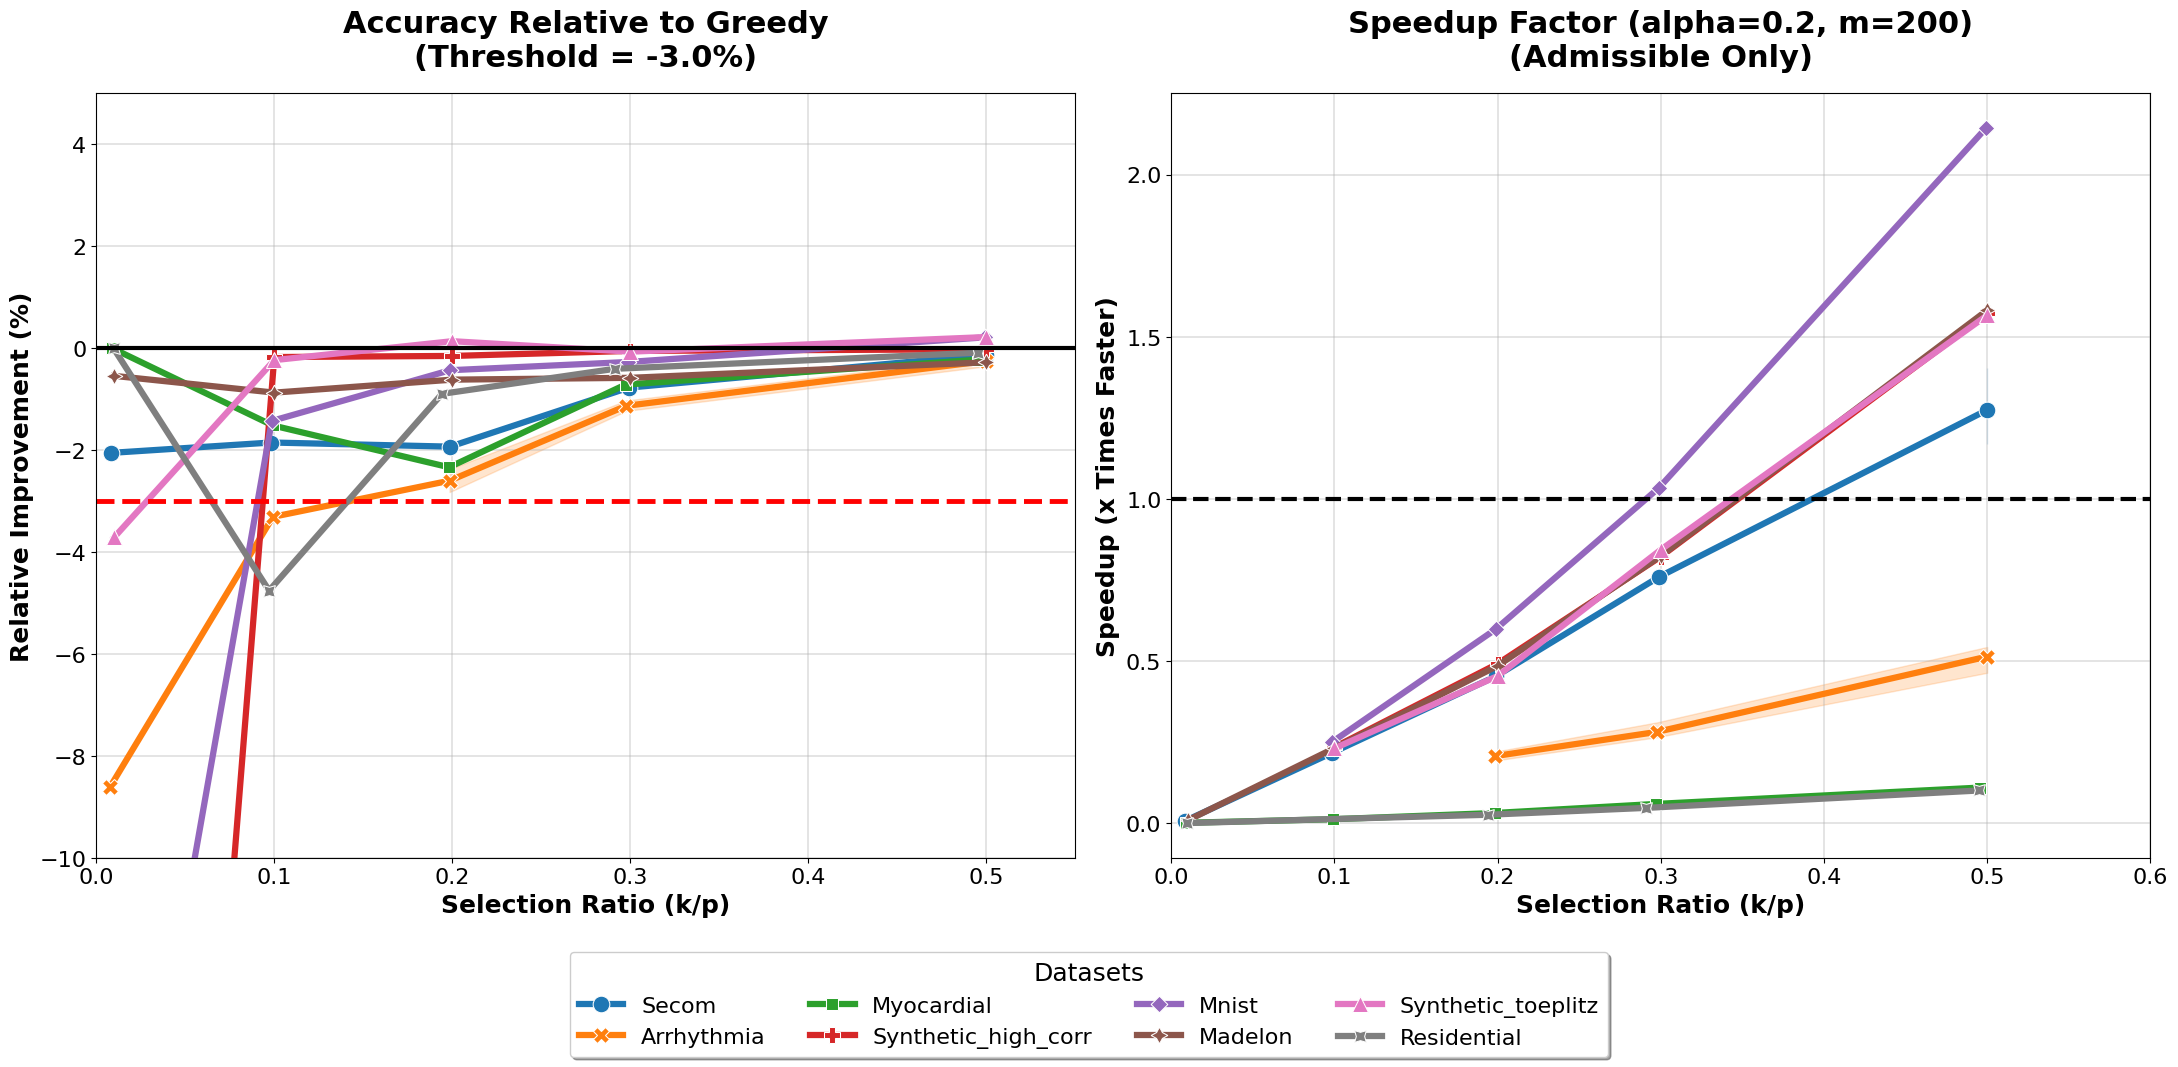

No data found for these parameters.


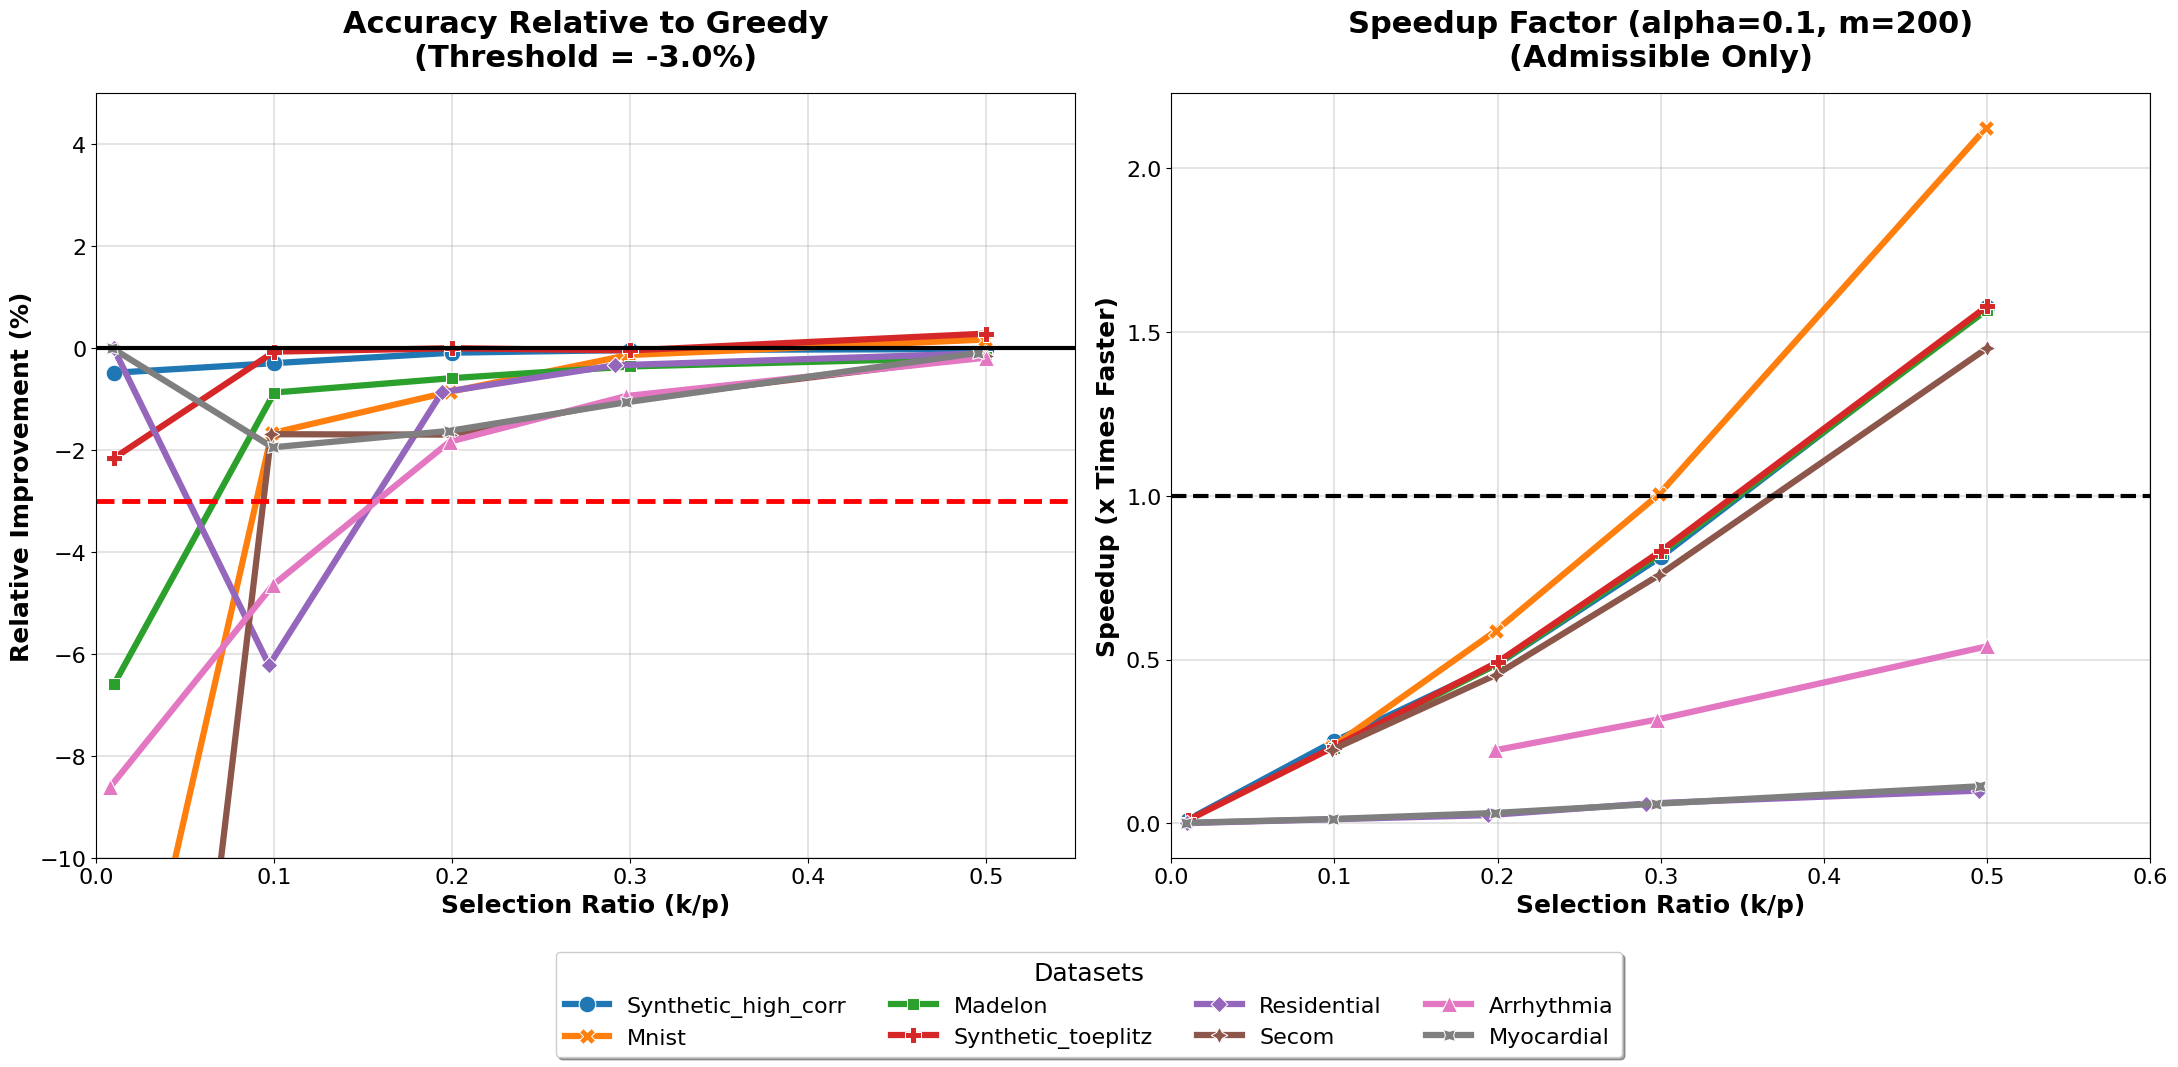

No data found for these parameters.


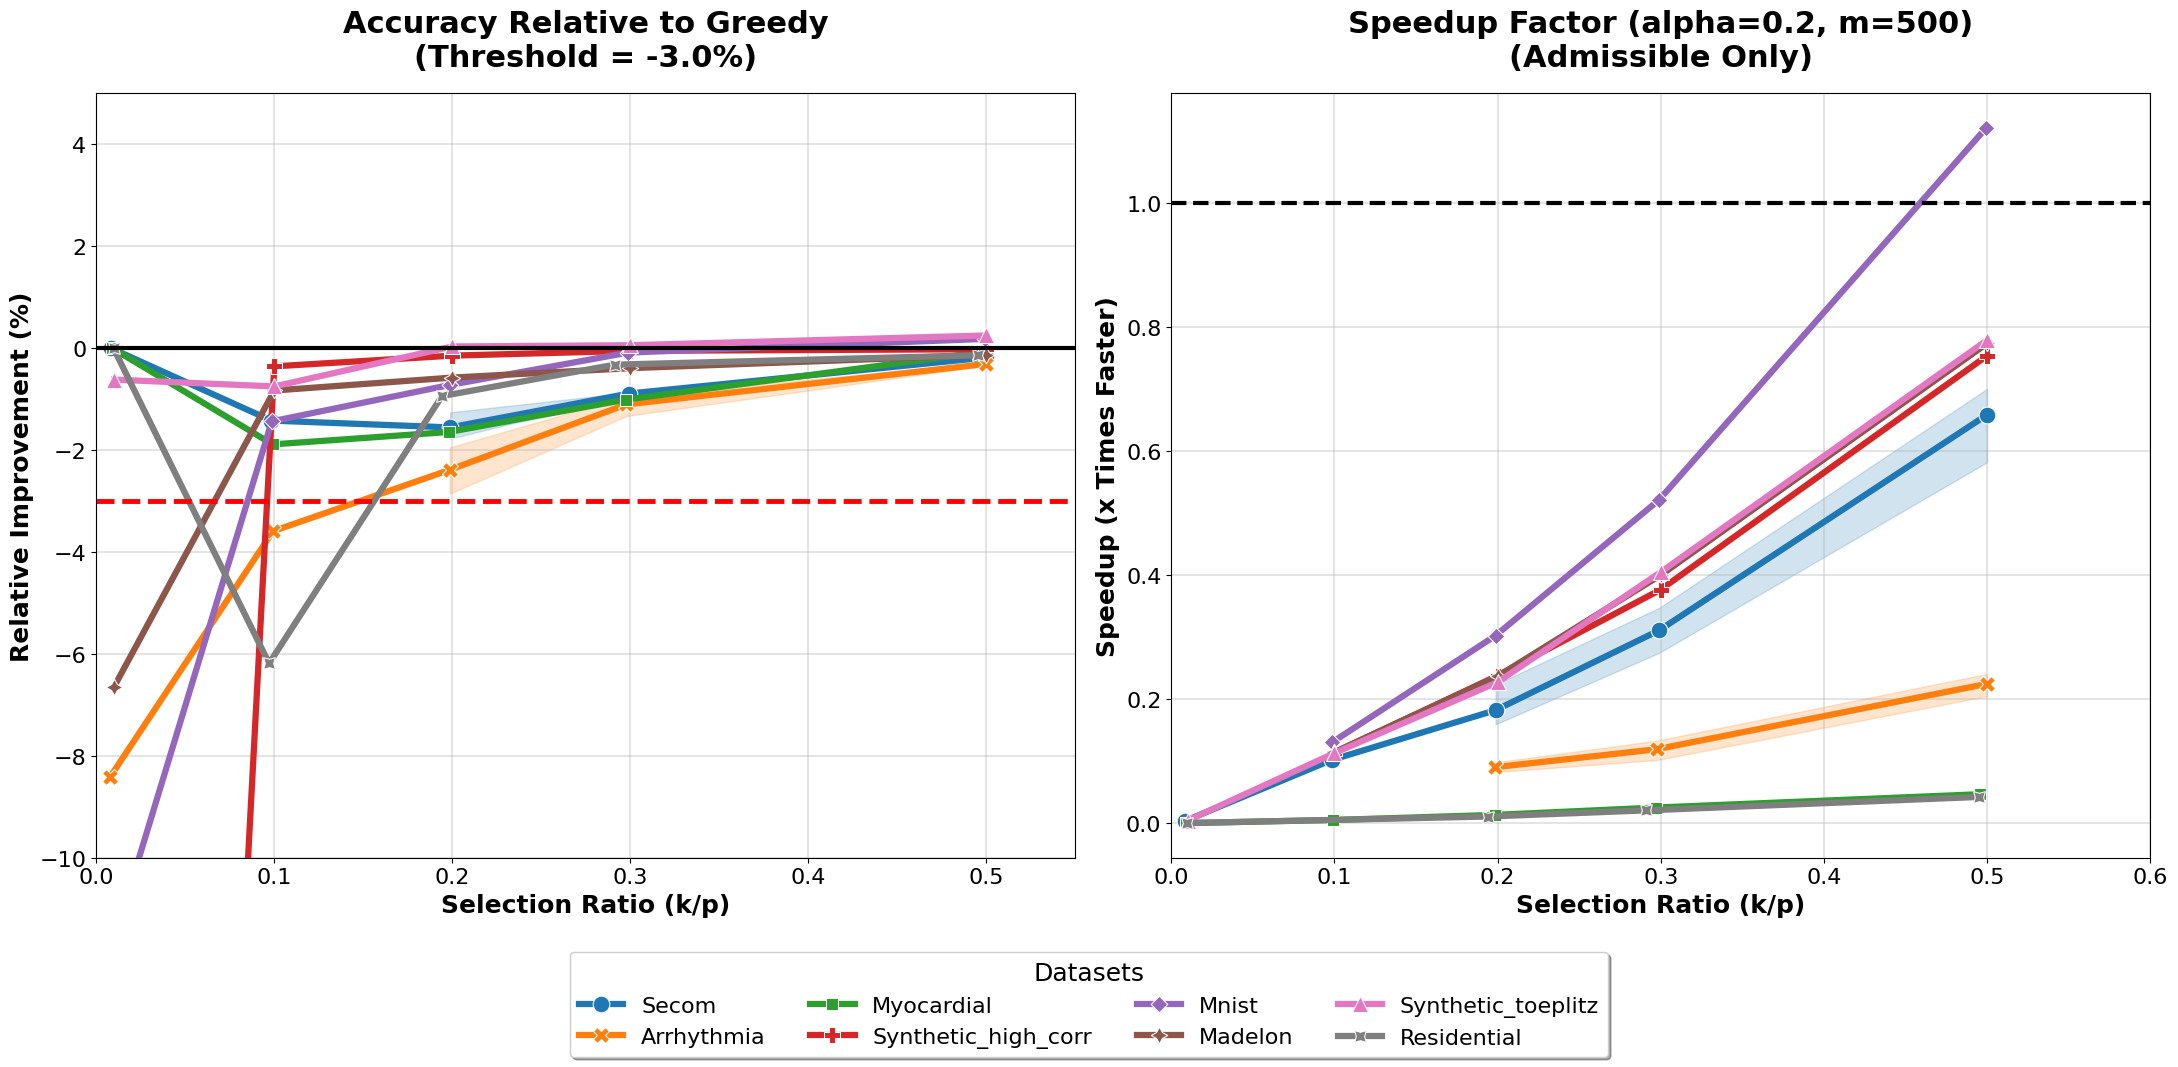

No data found for these parameters.
No data found for the specified parameters.
No data found for these parameters.


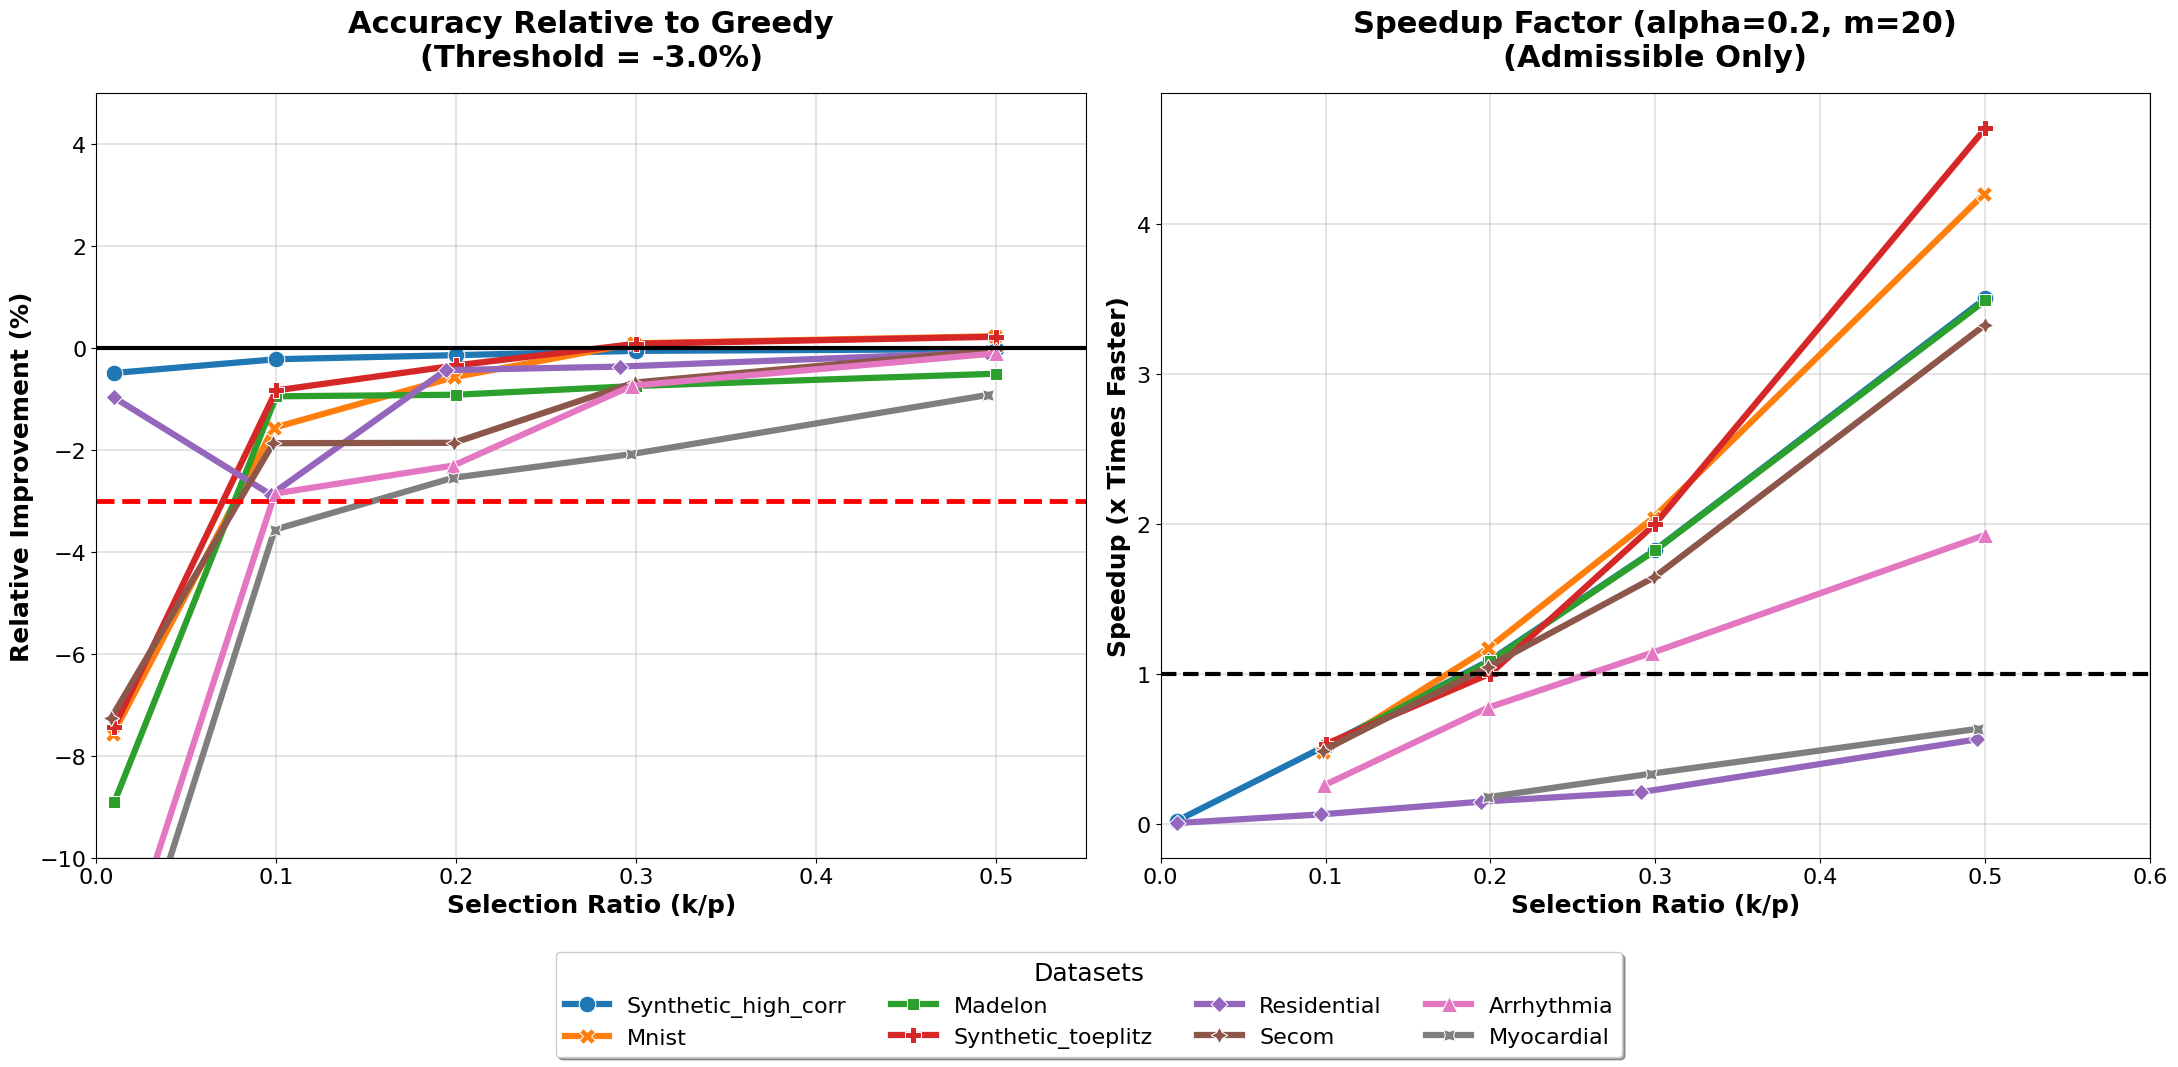

No data found for these parameters.


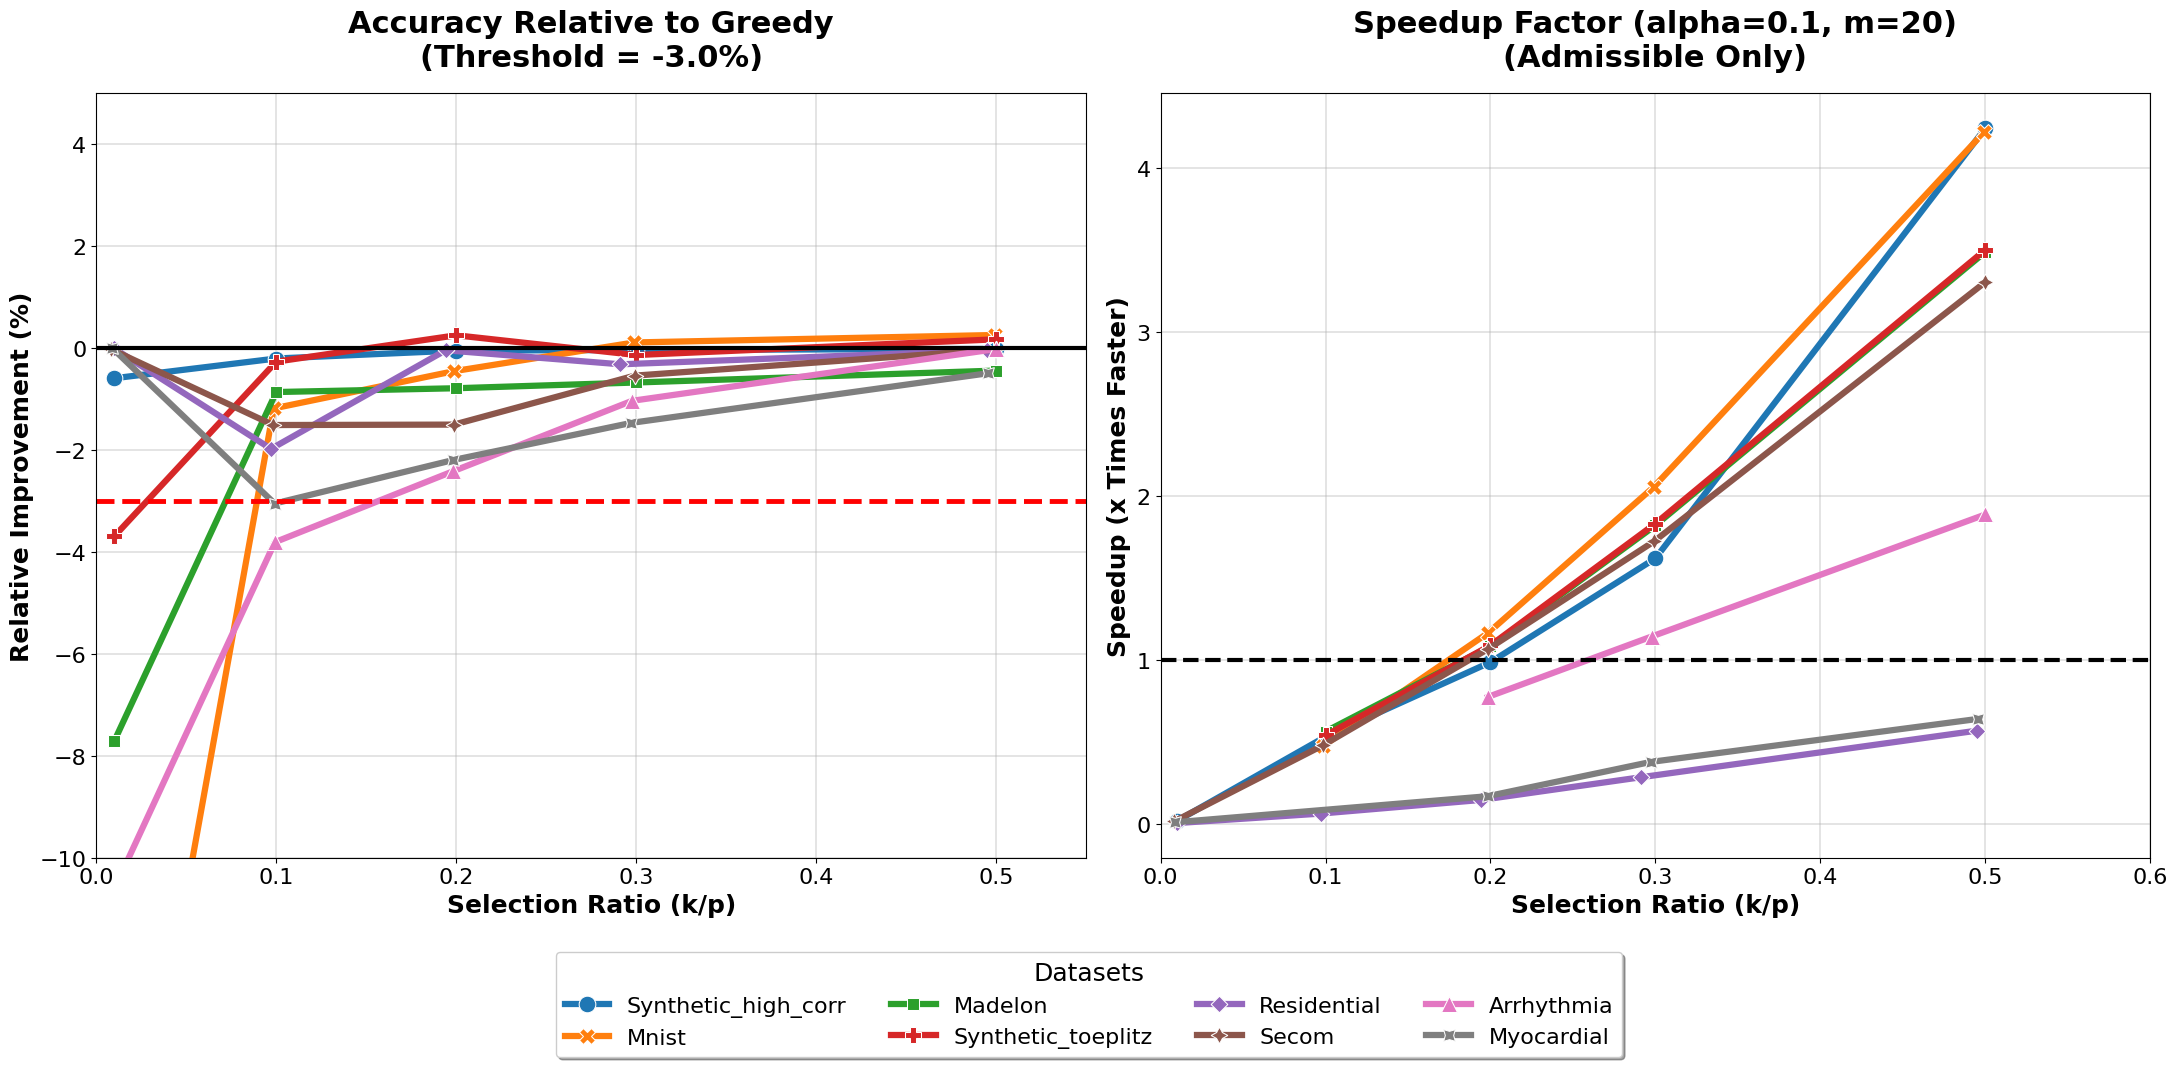

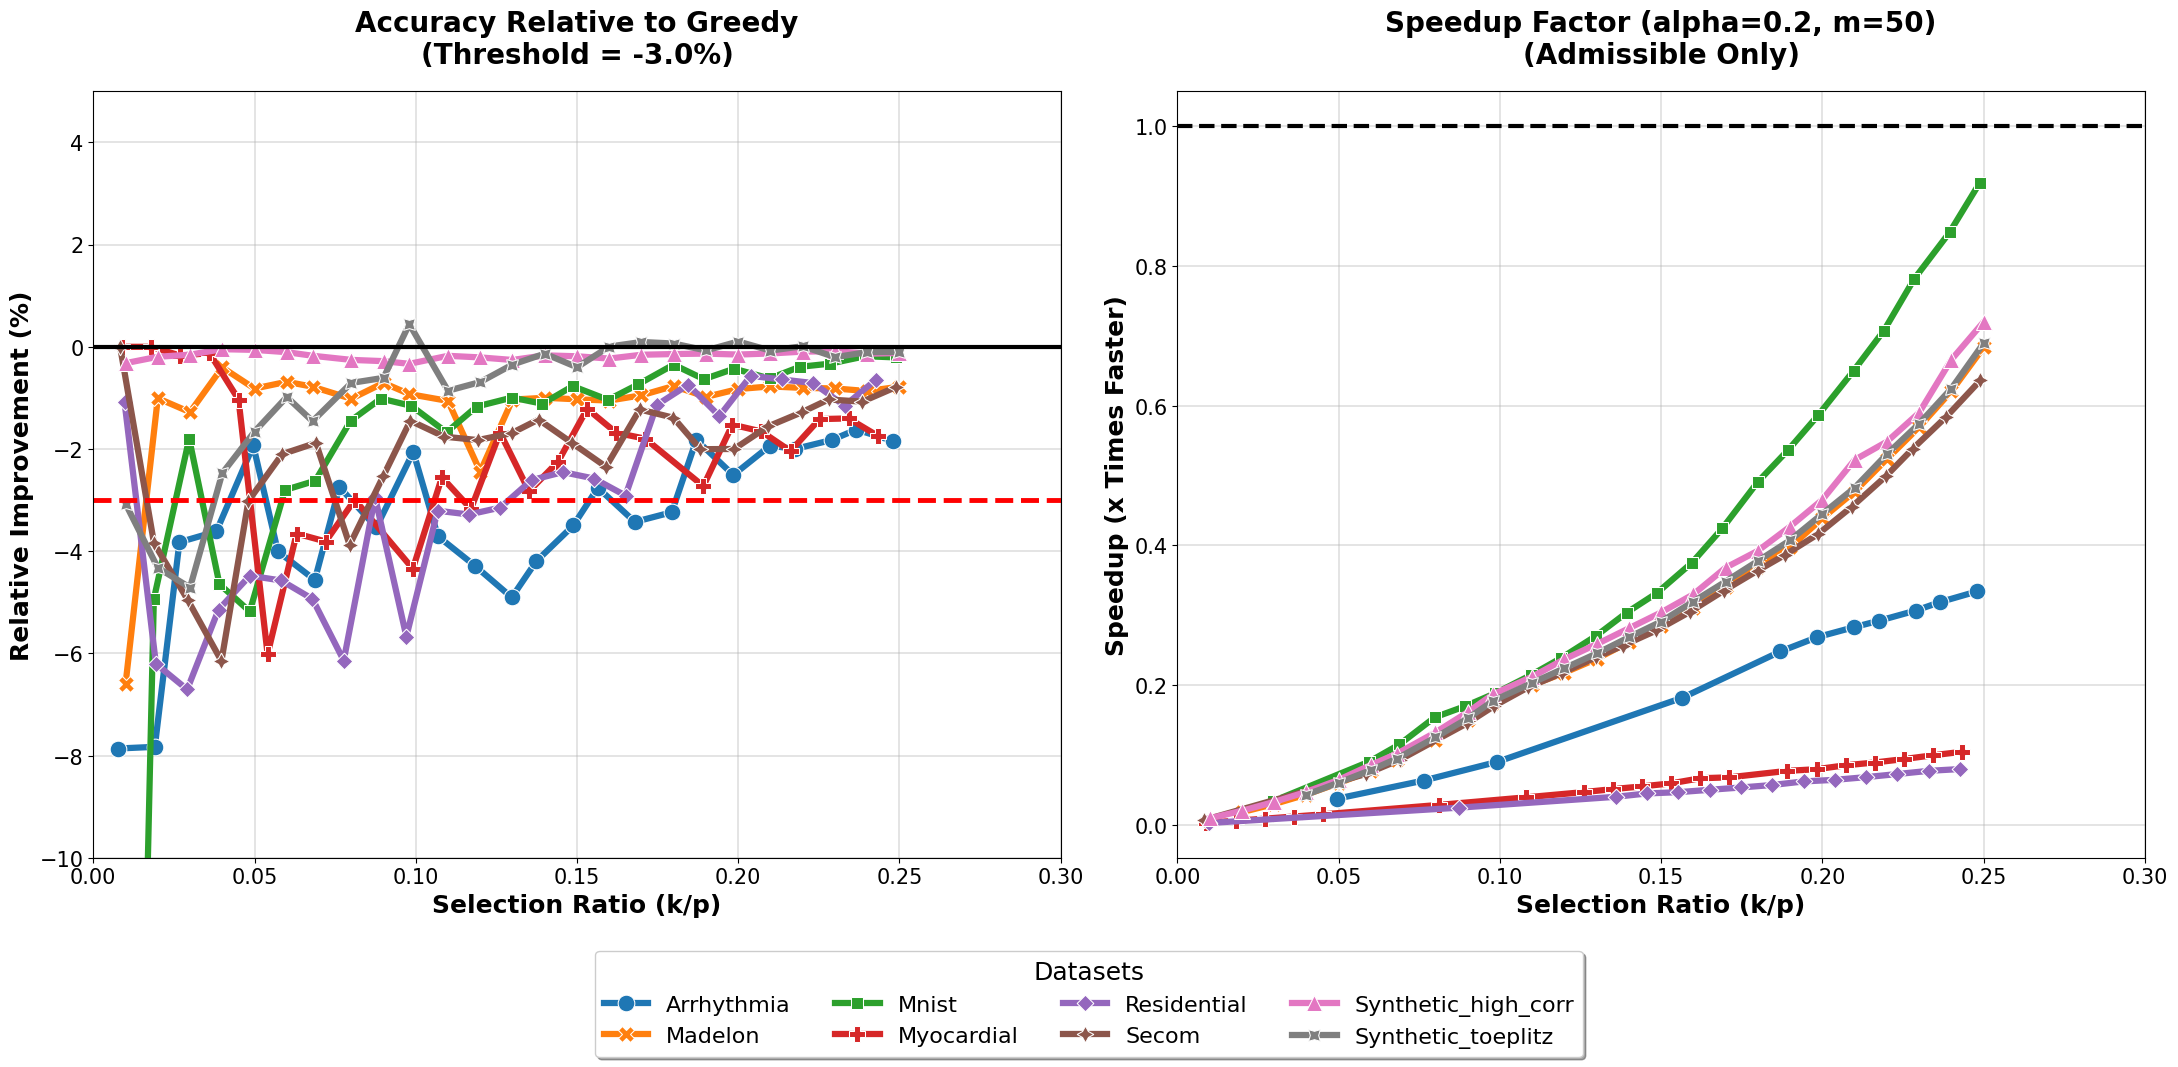

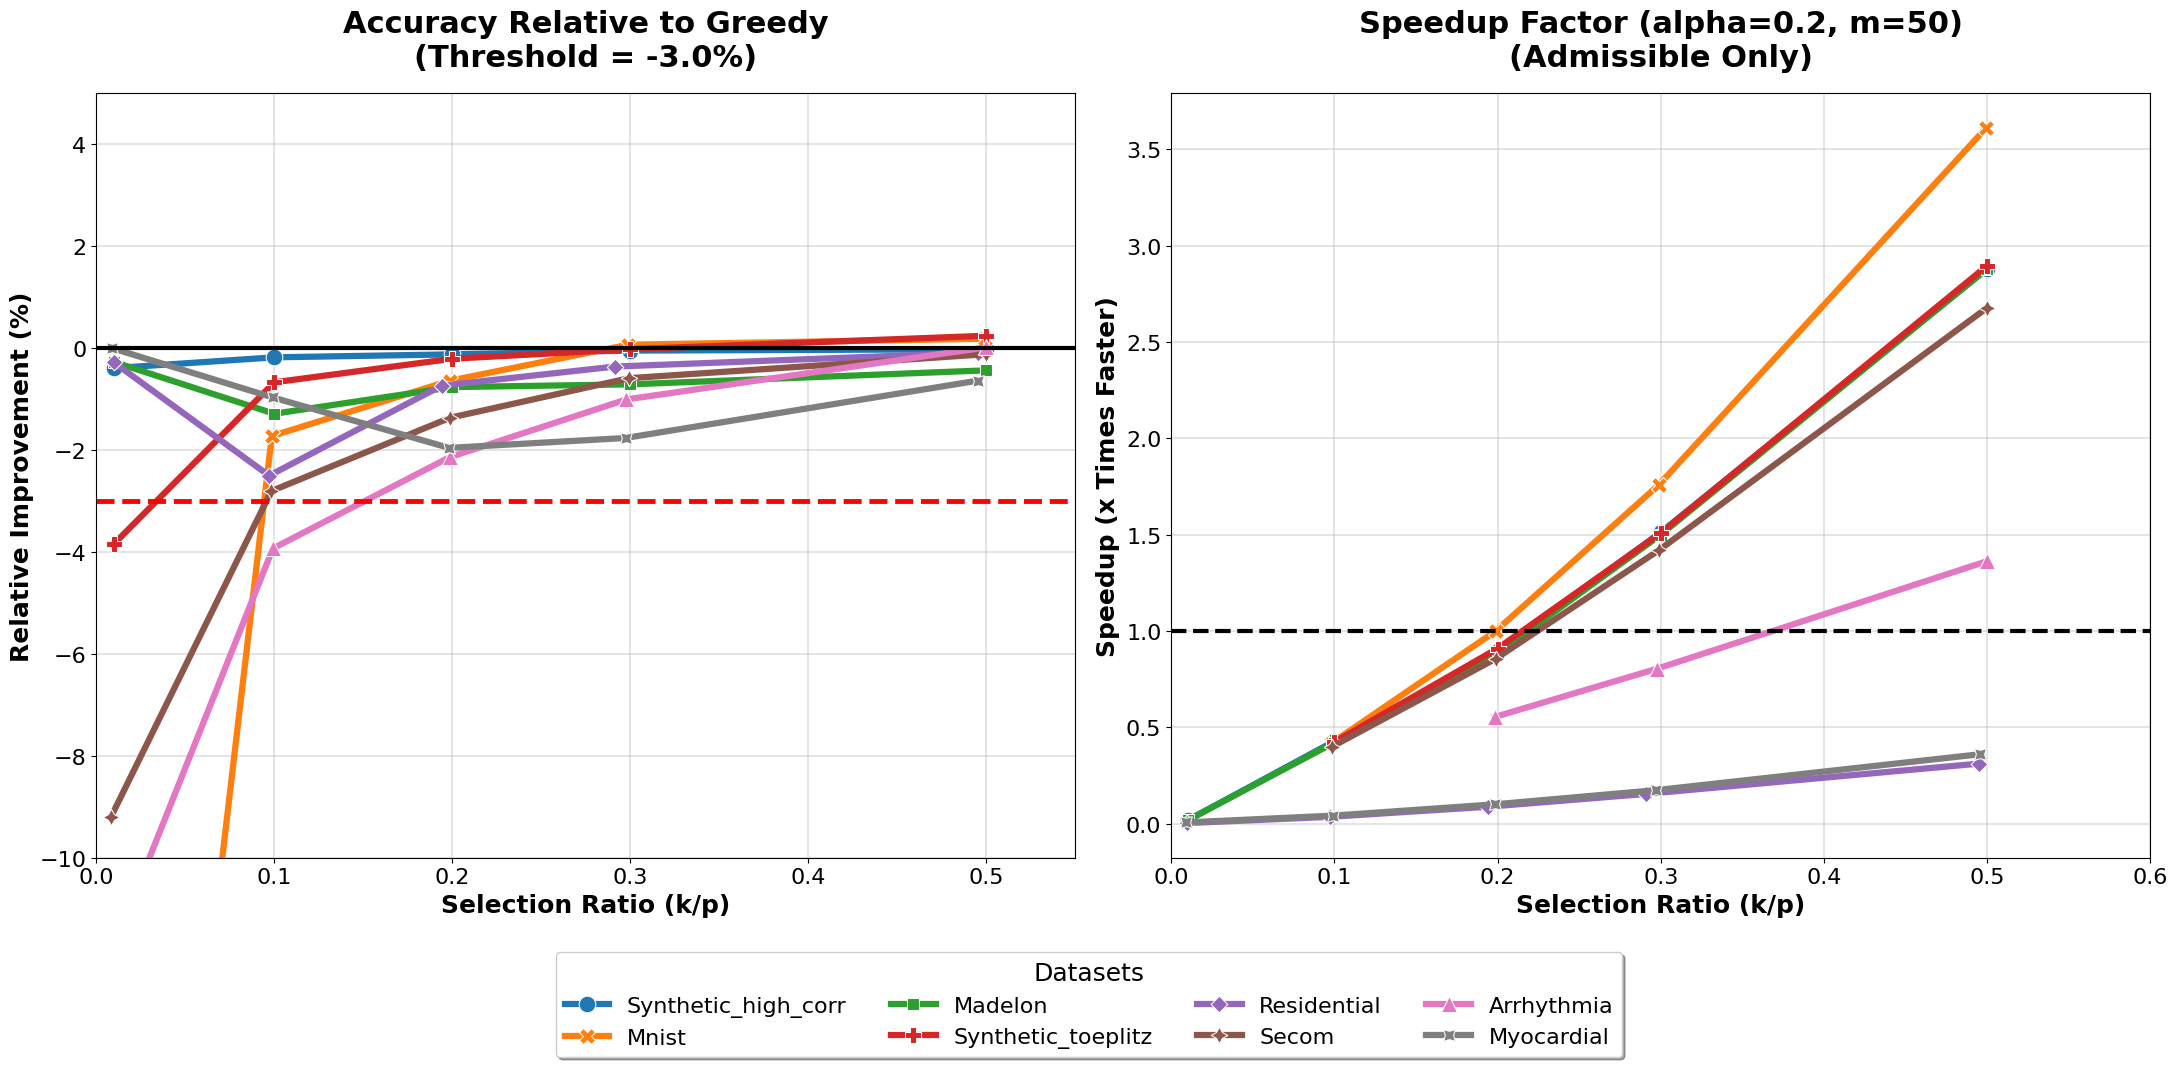

No data found for these parameters.


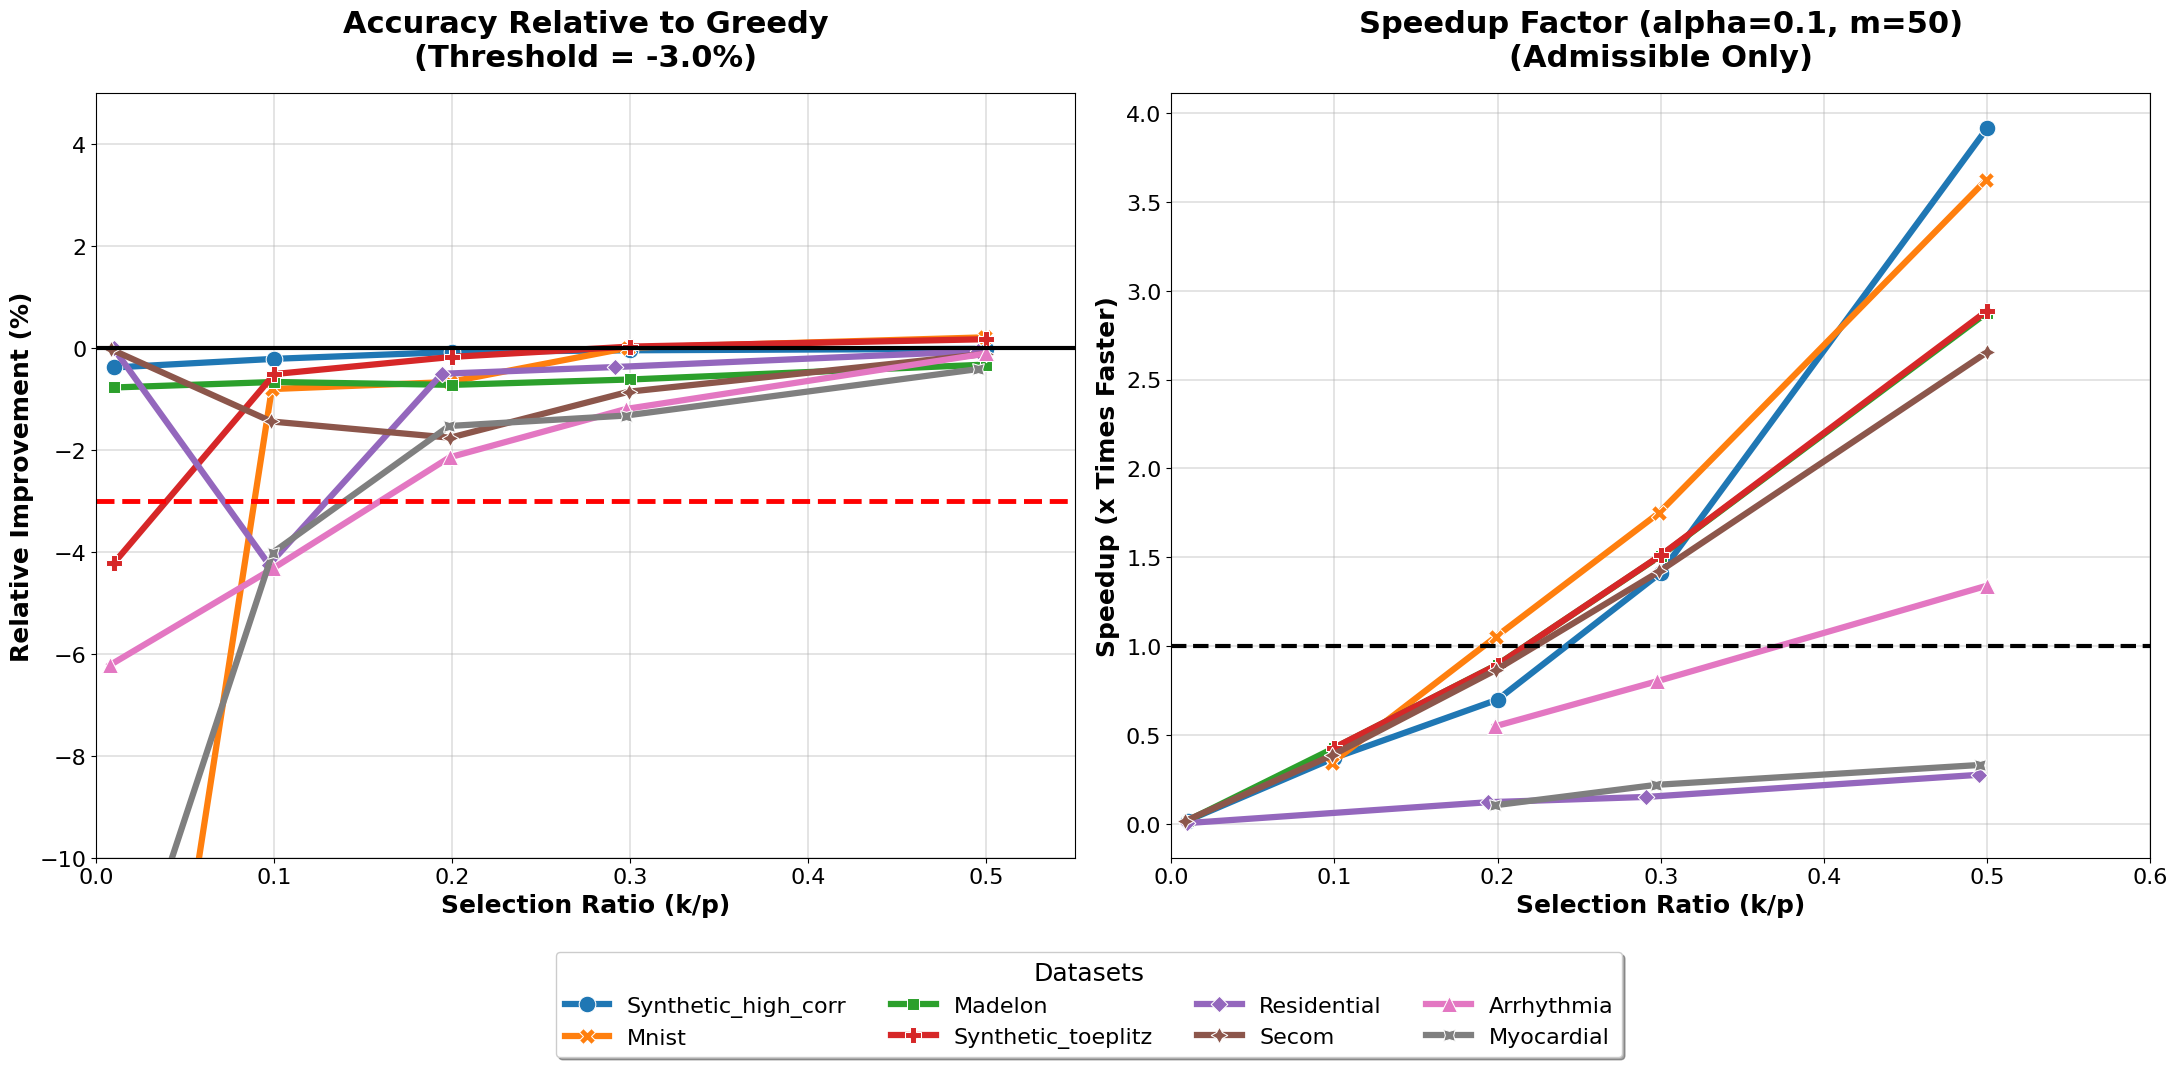

No data found for these parameters.


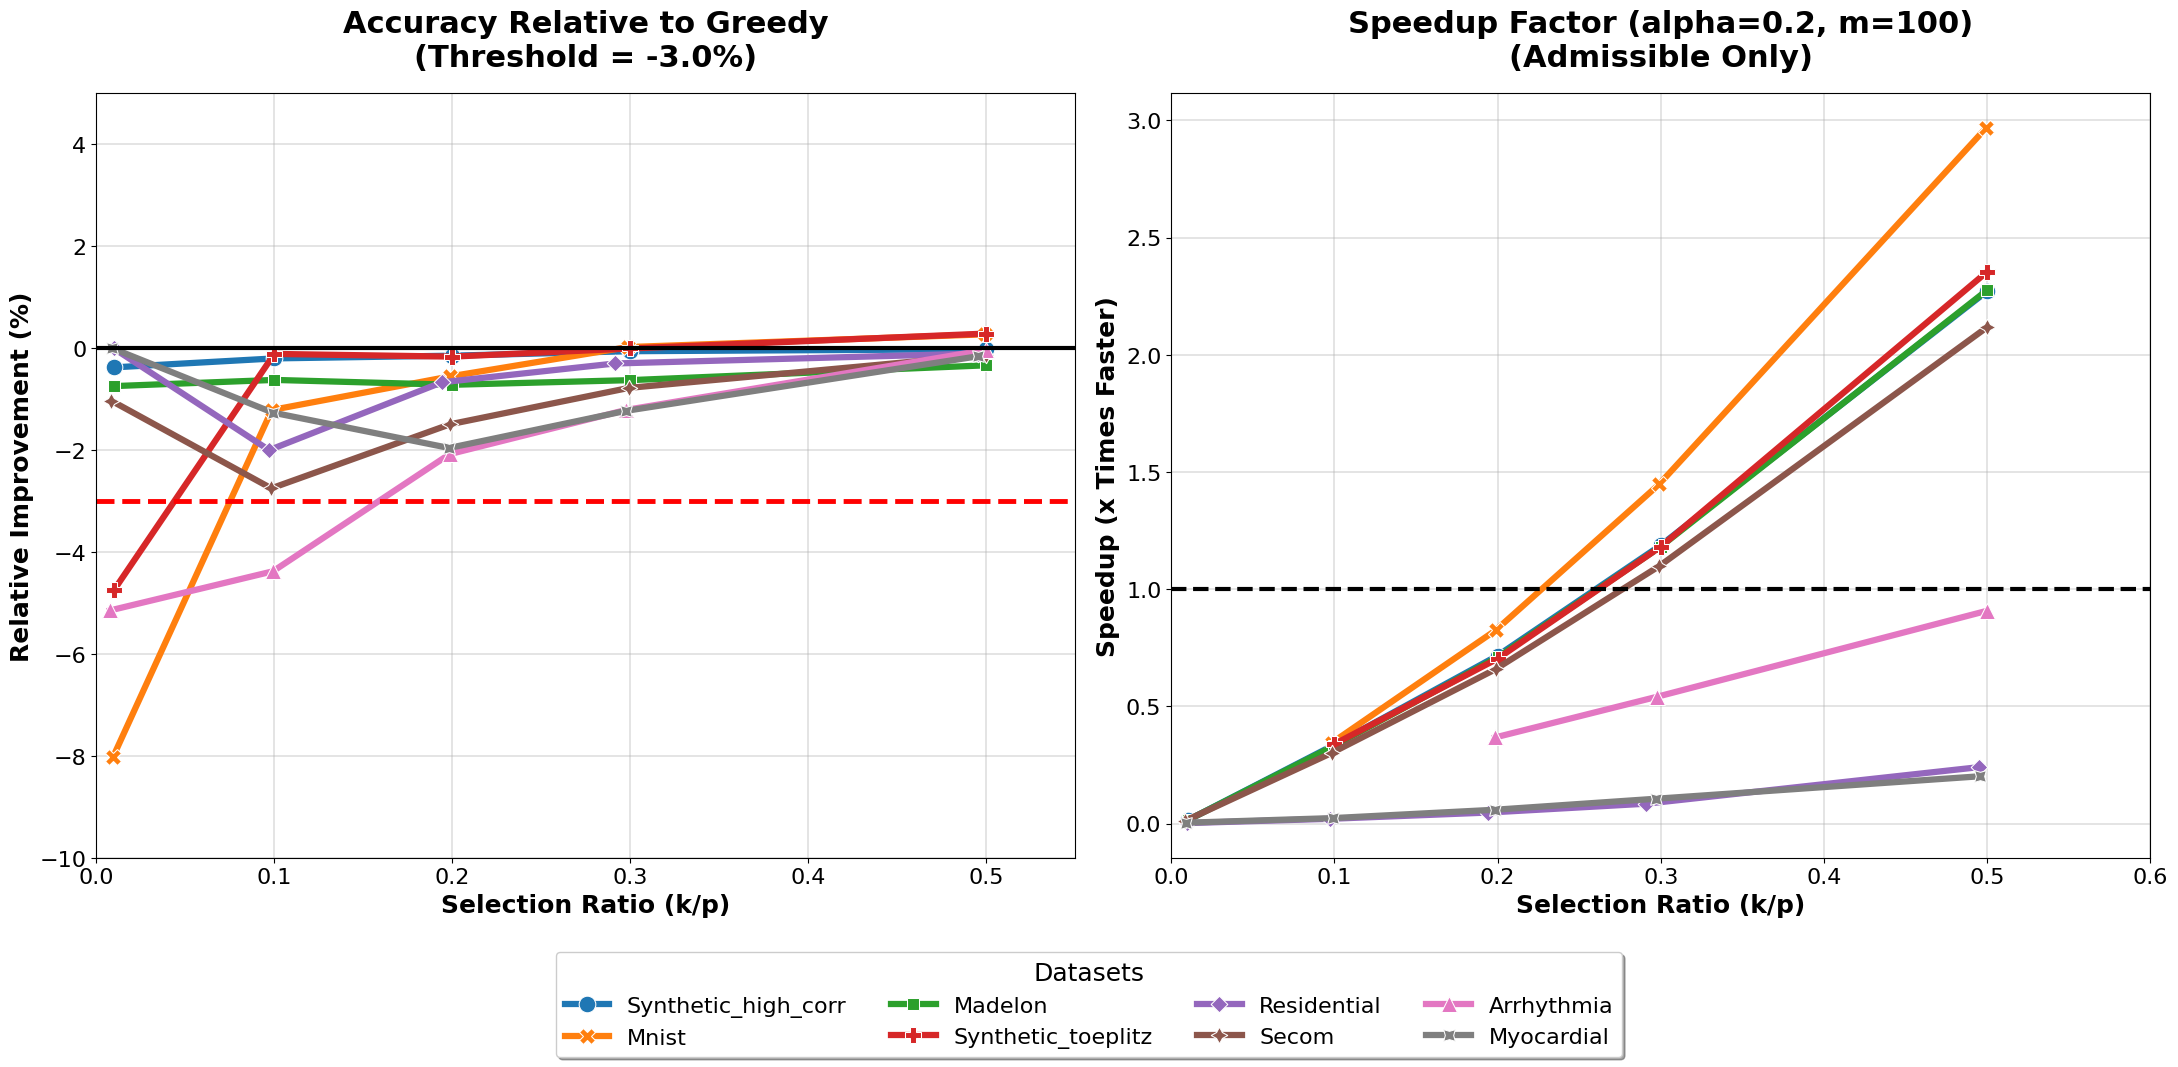

No data found for these parameters.


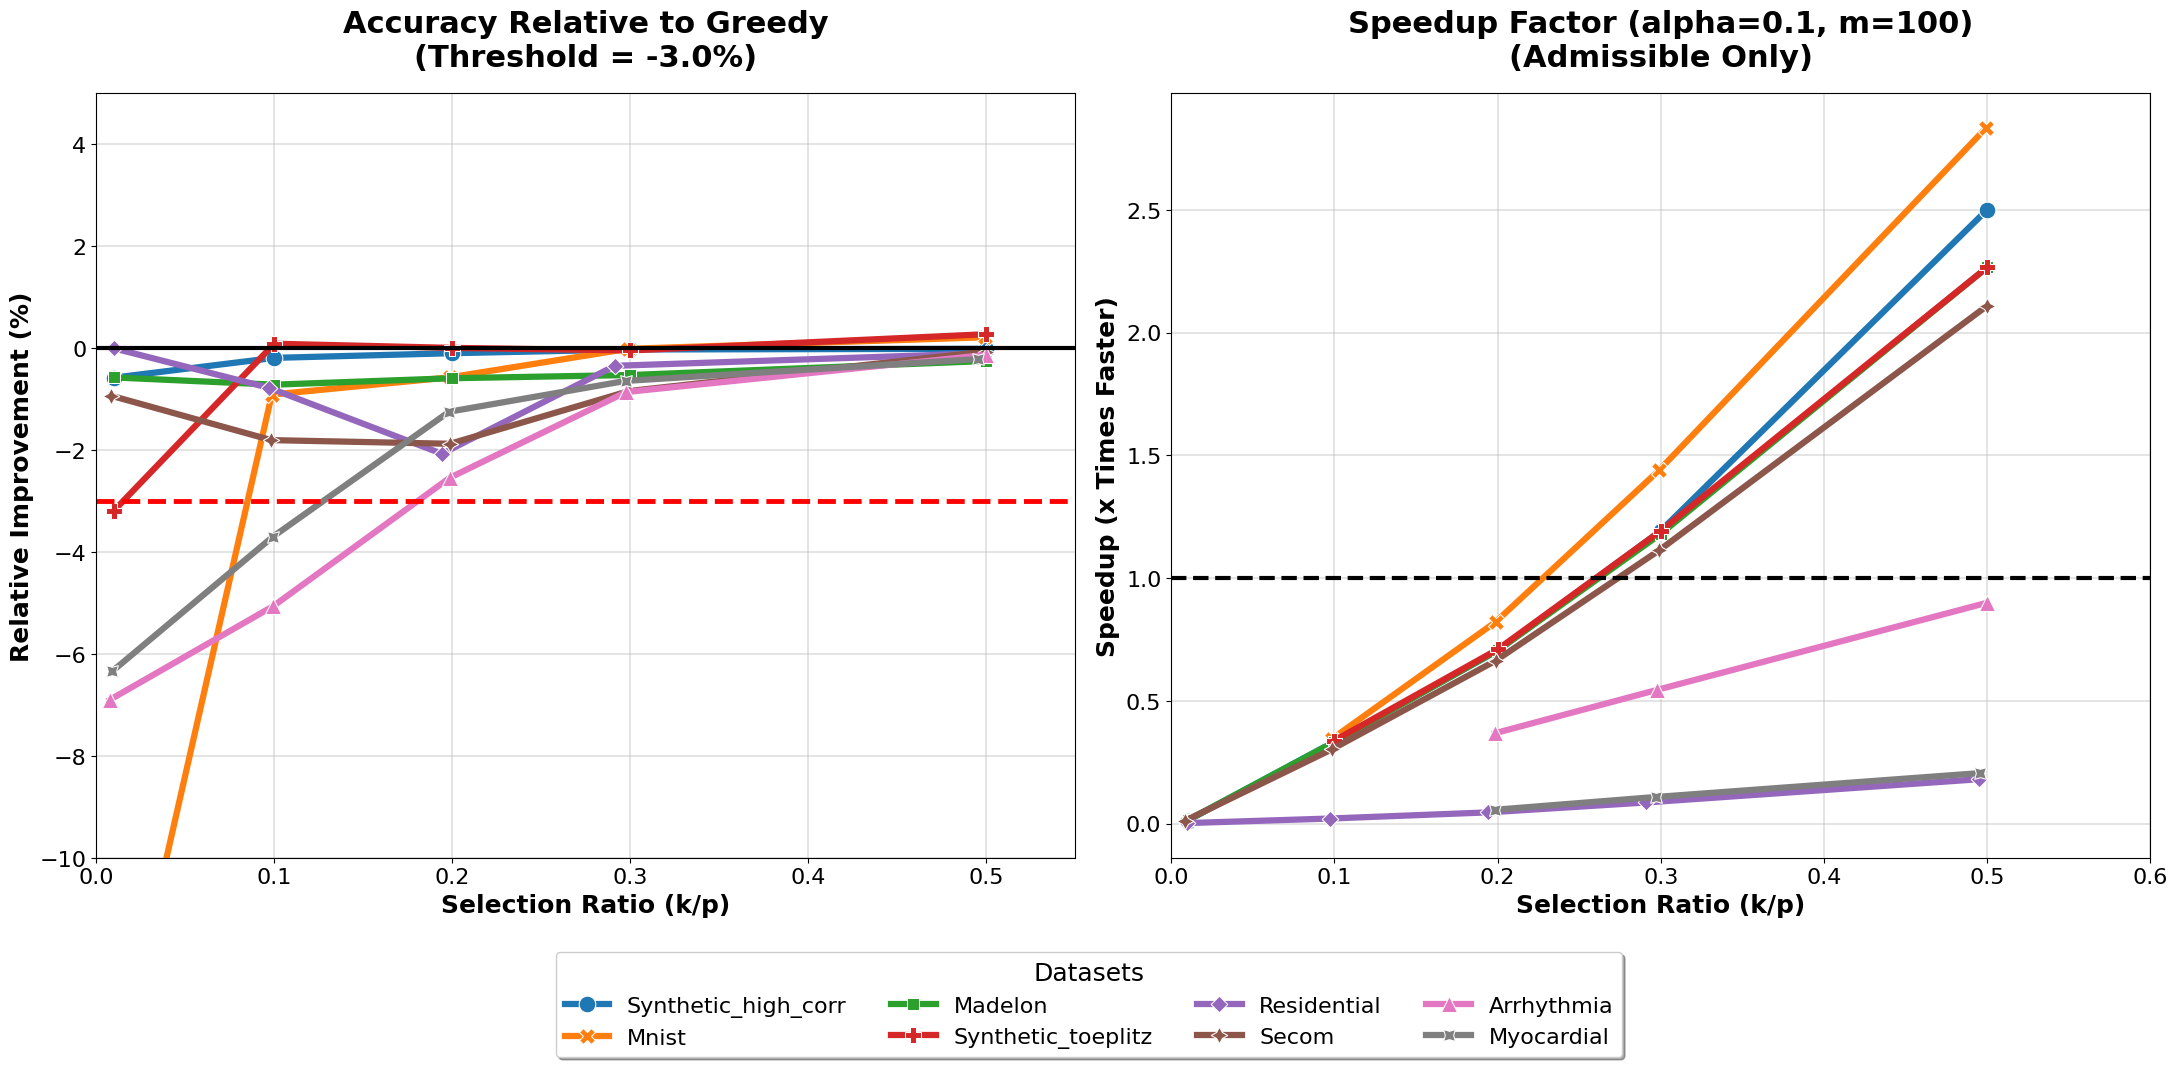

In [92]:
targets = ["synthetic_high_corr", "synthetic_toeplitz", "mnist", "residential", "secom", "myocardial", "arrhythmia", "madelon"] 
# Try with a tolerance of -3% (or -5% if you want to be lenient)
for s in df['samples'].unique():
    for a in df['alpha'].unique():
        plot_small_k(sparse_df, targets, samples=s, fixed_alpha=a, tolerance_threshold=-3.0)
        plot_admissible_speedup_annotated(df, targets, samples=s, fixed_alpha=a, tolerance_threshold=-3.0)